In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
if sys.version_info[0] < 3: 
    import StringIO
else:
    from io import StringIO


In [2]:
def getFilenames(dirname = "../data/"):
    filenames = []
    for file in os.listdir(dirname):
        if file.endswith(".txt"):
            filenames.append(os.path.join(dirname,file))
    return filenames

filenames = getFilenames()


In [3]:
frames = []
test_num_offset = 0
for name in filenames:
    print(name)
    file = open(name,'r')
    data = file.readlines()
    data = data[2:]
    
    numfields = len(data[0].split(", "))
    print(numfields)
    if numfields == 6:
        labels = ['test_num', 'location_num', 'mag_x', 'mag_y', 'mag_z', 'temp','time']
    else:
        labels = ['test_num', 'location_num', 'mag_x', 'mag_y', 'mag_z', 'temp', 'weight','time']

    test = []
    lastnum = 0
    tests = []
    time = 0
    for datum in data:
        datum = datum.replace("[","")
        datum = datum.replace("]","")
        datum = datum.replace("\n","")
        datum = [float(field) for field in datum.split(", ")]
        datum[0] = int(datum[0]+test_num_offset) 
        testnum = datum[0]
        time+=1
        
        if testnum != lastnum:
            tests.append(test)
            test = []
            lastnum = testnum
            time =0

            
        datum.append(time)
        test.append(tuple(datum))

    tests.append(test)
    test_num_offset = testnum+1
    for test in tests:
        frame = pd.DataFrame.from_records(test,columns=labels)
        frames.append(frame)
    

full_dataset = pd.concat(frames,sort=False)
full_dataset.test_num = full_dataset.test_num.astype(int)
dataset = full_dataset

test_nums = np.unique(dataset['test_num'])
y = np.zeros(len(test_nums))
for num in test_nums:
    y[num] = dataset.query('test_num=={}'.format(num))['location_num'].iloc[0]


../data/2019-1-24 N48_DM_UD_S1_T3.txt
6
../data/2019-2-17 N48_DM_UD_S4_T1.txt
6
../data/2019-1-24 N48_DM_UD_S1_T6.txt
6
../data/2019-2-20 N48_DM_UD_S2_T1.txt
6
../data/2019-2-17 N48_DM_UD_S4_T2.txt
6
../data/2019-1-24 N48_DM_UD_S1_T8.txt
6
../data/2019-2-18 N48_DM_UD_S4_T9.txt
7
../data/2019-2-18 N48_DM_UD_S4_T7.txt
7
../data/2019-1-24 N48_DM_UD_S1_T2.txt
6
../data/2019-2-19 N48_DM_UD_S3_T3.txt
7
../data/2019-2-19 N48_DM_UD_S3_T4.txt
7
../data/2019-1-24 N48_DM_UD_S1_T1.txt
6
../data/2019-1-24 N48_DM_UD_S1_T7.txt
6
../data/2019-2-19 N48_DM_UD_S3_T6.txt
7
../data/2019-1-24 N48_DM_UD_S1_T5.txt
6
../data/2019-1-24 N48_DM_UD_S1_T4.txt
6
../data/2019-2-17 N48_DM_UD_S4_T6.txt
6
../data/2019-2-17 N48_DM_UD_S4_T4.txt
6
../data/2019-2-17 N48_DM_UD_S4_T5.txt
6
../data/2019-2-20 N48_DM_UD_S2_T3.txt
6
../data/2019-2-19 N48_DM_UD_S3_T2.txt
7
../data/2019-2-20 N48_DM_UD_S2_T2.txt
6
../data/2019-2-19 N48_DM_UD_S3_T8.txt
7
../data/2019-2-20 N48_DM_UD_S2_T4.txt
6
../data/2019-2-19 N48_DM_UD_S3_T1.txt
7


In [4]:
dataset

,test_num,location_num,mag_x,mag_y,mag_z,temp,time,weight
0,0,13.0,116.40,227.55,-835.14,19.14,1,NaN
1,0,13.0,125.25,228.00,-851.36,18.85,2,NaN
2,0,13.0,126.45,223.65,-853.05,18.96,3,NaN
3,0,13.0,125.85,226.35,-848.94,19.07,4,NaN
4,0,13.0,128.70,222.60,-848.94,18.94,5,NaN
5,0,13.0,126.15,222.60,-849.90,18.96,6,NaN
6,0,13.0,125.70,225.45,-850.15,18.98,7,NaN
7,0,13.0,127.95,226.35,-847.48,18.83,8,NaN
8,0,13.0,126.75,224.40,-850.15,18.89,9,NaN
9,0,13.0,128.70,225.90,-851.36,18.87,10,NaN


In [5]:
full_dataset

,test_num,location_num,mag_x,mag_y,mag_z,temp,time,weight
0,0,13.0,116.40,227.55,-835.14,19.14,1,NaN
1,0,13.0,125.25,228.00,-851.36,18.85,2,NaN
2,0,13.0,126.45,223.65,-853.05,18.96,3,NaN
3,0,13.0,125.85,226.35,-848.94,19.07,4,NaN
4,0,13.0,128.70,222.60,-848.94,18.94,5,NaN
5,0,13.0,126.15,222.60,-849.90,18.96,6,NaN
6,0,13.0,125.70,225.45,-850.15,18.98,7,NaN
7,0,13.0,127.95,226.35,-847.48,18.83,8,NaN
8,0,13.0,126.75,224.40,-850.15,18.89,9,NaN
9,0,13.0,128.70,225.90,-851.36,18.87,10,NaN


In [6]:
dat1000 = dataset.query('test_num==69')

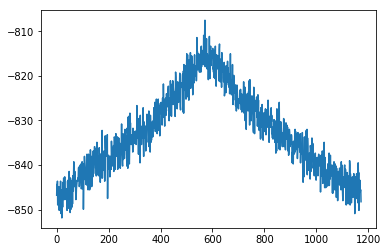

In [7]:
plt.plot(np.array(dat1000['time']),np.array(dat1000['mag_z']))

In [8]:
dataset=dataset.drop(columns = ['location_num','weight','temp'])

In [9]:
np.save('../data/y.npy',y)
np.save('../data/dataset.npy',np.array(dataset))

Now that dataset is created, let's extract some features!

In [10]:
import numpy as np
import pandas as pd
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters


In [11]:
data=np.load('../data/dataset.npy')
labels = ['test_num', 'mag_x', 'mag_y', 'mag_z','time']
dataset = pd.DataFrame({ labels[0]:data[:,0].astype(int) , labels[1]:data[:,1] , labels[2]:data[:,2], \
labels[3]:data[:,3],labels[4]:data[:,4]})
y = np.load('../data/y.npy')
y = pd.Series(y.astype(int))


In [12]:
dataset

,test_num,mag_x,mag_y,mag_z,time
0,0,116.4,227.55,-835.14,1
1,0,125.25,228,-851.36,2
2,0,126.45,223.65,-853.05,3
3,0,125.85,226.35,-848.94,4
4,0,128.7,222.6,-848.94,5
5,0,126.15,222.6,-849.9,6
6,0,125.7,225.45,-850.15,7
7,0,127.95,226.35,-847.48,8
8,0,126.75,224.4,-850.15,9
9,0,128.7,225.9,-851.36,10


In [13]:
features =  extract_relevant_features(dataset, y, column_id='test_num', column_sort='time', default_fc_parameters=MinimalFCParameters())
features.to_pickle('../data/features.pkl')

Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


In [14]:
features.shape

(7625, 24)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


In [16]:
X = pd.read_pickle('../data/features.pkl')
y = np.load('../data/y.npy')
y = pd.Series(y.astype(int))
N = len(X)

rs = ShuffleSplit(n_splits=5, test_size=.20, random_state=8)
for tr,tst in rs.split(X):
    train_x = np.array(X)[tr]
    train_y = np.array(y)[tr]
    test_x = np.array(X)[tst]
    test_y = np.array(y)[tst]

In [17]:
def evalModel(model,train_x,train_y,test_x,test_y):
    y_hat = model.predict(test_x)
    print('Predicted classes: {0}'.format(np.unique(y_hat)))
    print('Training score: {0}'.format(model.score(train_x,train_y)))
    print('Test score: {0}'.format(model.score(test_x,test_y)))
    plt.matshow(confusion_matrix(test_y,y_hat))

Predicted classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Training score: 1.0
Test score: 0.9718032786885246


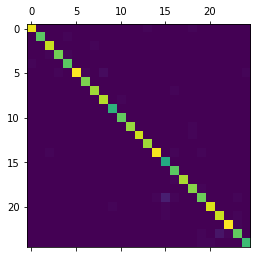

In [18]:
forest = RandomForestClassifier(n_estimators=200)
forest.fit(train_x,train_y)
evalModel(forest,train_x,train_y,test_x,test_y)

Predicted classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Training score: 1.0
Test score: 0.741639344262295


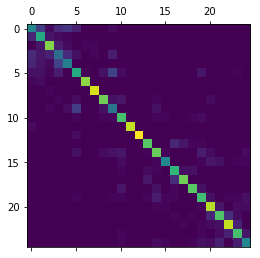

In [19]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_x,train_y)
evalModel(knn,train_x,train_y,test_x,test_y)


In [20]:
tabs = np.abs(train_x)
tmax = np.max(tabs,axis=0).reshape(1,-1)
norms = np.matlib.repmat(tmax,train_x.shape[0],1)
train_xnorm = train_x/norms

Predicted classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 21 22 23 24]
Training score: 0.25606557377049183
Test score: 0.25245901639344265


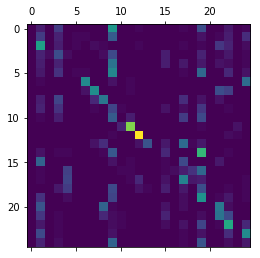

In [21]:
hidden = 100
mlp = MLPClassifier(solver ='adam',learning_rate_init = 0.0001, hidden_layer_sizes=(hidden,hidden),max_iter=int(1e8),random_state=8)
mlp.fit(train_x,train_y)
evalModel(mlp,train_x,train_y,test_x,test_y)

(array([255.,  44.,  79., 302., 139.,  17., 157., 245.,  88., 199.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <a list of 10 Patch objects>)

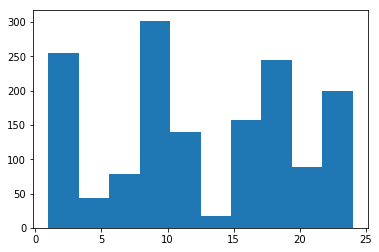

In [22]:
plt.hist(mlp.predict(test_x))


(array([191., 112., 195., 110., 115., 201.,  96., 186., 136., 183.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

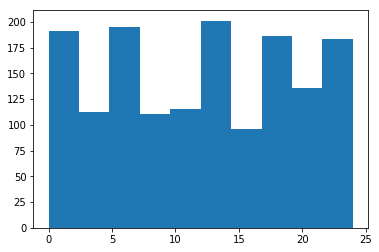

In [23]:
plt.hist(test_y)